# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
! pip install datasets


In [2]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random
import numpy as np

# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [3]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [4]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Explore the dataset
# For example, print the column names and display a few sample rows
# TODO: your code goes here
dataset

DatasetDict({
    train: Dataset({
        features: ['SMILES', 'label'],
        num_rows: 4200
    })
})

In [6]:
print(dataset["train"].features)


{'SMILES': Value(dtype='string', id=None), 'label': Value(dtype='float64', id=None)}


In [7]:
print(dataset["train"][:5])


{'SMILES': ['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', 'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', 'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', 'OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3', 'Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1'], 'label': [3.54, -1.18, 3.69, 3.37, 3.1]}


In [8]:
dataset["train"].features


{'SMILES': Value(dtype='string', id=None),
 'label': Value(dtype='float64', id=None)}

In [9]:
# to calculate the strings length
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Sample a subset of the dataset
sample_data = dataset["train"][:1000]

# Check the structure of sample_data by printing its keys
print("Keys in sample_data:", sample_data.keys())

# Since sample_data is a dictionary with columns as keys, extract the SMILES strings.
sample_smiles = sample_data["SMILES"]

# Tokenize each SMILES string and get the token count.
token_lengths = [len(tokenizer.tokenize(smile)) for smile in sample_smiles]

# Calculate and print some statistics
import statistics
avg_length = statistics.mean(token_lengths)
median_length = statistics.median(token_lengths)
max_length_sample = max(token_lengths)

print("Average tokenized length:", avg_length)
print("Median tokenized length:", median_length)
print("Maximum tokenized length in sample:", max_length_sample)


Keys in sample_data: dict_keys(['SMILES', 'label'])
Average tokenized length: 44.79
Median tokenized length: 46.0
Maximum tokenized length in sample: 117


In [10]:
# define a PyTorch Dataset class for handling SMILES strings and targets

# TODO: your code goes here
class SMILESDataset(Dataset):

  def __init__(self, data, tokenizer, max_length):
      self.data = data
      self.tokenizer = tokenizer
      self.max_len = max_length

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      row = self.data[idx]
      SMILES = row['SMILES']
      label = row['label']

      inputs = self.tokenizer.encode_plus(
      SMILES,
      add_special_tokens=True,
      max_length=self.max_len,
      padding='max_length',
      return_token_type_ids=False,
      truncation=True
  )

      return {
    'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
    'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
    'target': torch.tensor(label, dtype=torch.float)  # Directly convert the target to float
}



## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [11]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

In [12]:
# split the data into training and test datasets
# TODO: your code goes here
# https://stackoverflow.com/questions/76001128/splitting-dataset-into-train-test-and-validation-using-huggingface-datasets-fun


In [13]:
# First, split the 'train' split into train+validation and test (e.g., 80/20)
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_valid_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

# Then, split train_valid_dataset into train and validation (e.g., 90/10 of train_valid_dataset)
split_train_valid = train_valid_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_train_valid["train"]
valid_dataset = split_train_valid["test"]

print("Train samples:", len(train_dataset))
print("Validation samples:", len(valid_dataset))
print("Test samples:", len(test_dataset))


Train samples: 3024
Validation samples: 336
Test samples: 840


In [14]:
# construct Pytorch data loaders for both train and test datasets
BATCH_SIZE = 16 # adjust based on memory constraints

# TODO: your code goes here
# https://stackoverflow.com/questions/71662768/huggingface-datasets-to-pytorch

reg_train_dataset = SMILESDataset(train_dataset, tokenizer, max_length=128)
reg_valid_dataset = SMILESDataset(valid_dataset, tokenizer, max_length=128)
reg_test_dataset  = SMILESDataset(test_dataset, tokenizer, max_length=128)

reg_train_loader = DataLoader(reg_train_dataset, batch_size=16, shuffle=True)
reg_valid_loader = DataLoader(reg_valid_dataset, batch_size=16, shuffle=False)
reg_test_loader  = DataLoader(reg_test_dataset, batch_size=16, shuffle=False)

## --- Step 3: Load Model ---

In [15]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

In [16]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
    # TODO: your code goes here
  def __init__(self,model):
    super(MoLFormerWithRegressionHead, self).__init__()
    self.pretrained = model
    hidden_size = self.pretrained.config.hidden_size

    #dropout?

    self.regression = nn.Linear(hidden_size, 1)


  def forward(self, ids, mask):
    # pass input to the pre-trained model
    output = self.pretrained(ids, attention_mask=mask)
    # extracts the last hidden state
    hidden_states = output.last_hidden_state
    # selects the cls token, represents the summary of the entire sequence
    cls_representation = hidden_states[:, 0, :]

    output = self.regression(cls_representation)
    return output.squeeze(-1) # to remove the last dimension



In [17]:
# initialize the regression model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

## --- Step 4: Training ---

In [18]:
EPOCHS = 20
LEARNING_RATE = 1e-7

optimizer = torch.optim.Adam(params=regression_model.parameters(), lr=LEARNING_RATE)
loss_function = nn.MSELoss()

# Containers for later evaluation and plotting
train_loss_history = []
test_loss_history = []
all_train_predictions = []
all_train_targets = []
all_test_predictions = []
all_test_targets = []

for epoch in range(EPOCHS):
    regression_model.train()
    total_train_loss = 0.0
    train_bar = tqdm(reg_train_loader, desc=f"Epoch {epoch+1} - Training")

    # Containers for this epoch
    epoch_train_preds = []
    epoch_train_targs = []

    for batch in train_bar:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()
        output = regression_model(ids, mask)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        # Multiply by batch size for correct average calculation
        total_train_loss += loss.item() * ids.size(0)
        train_bar.set_postfix(loss=loss.item())

        # Save predictions and targets for this batch
        epoch_train_preds.extend(output.detach().cpu().numpy())
        epoch_train_targs.extend(target.detach().cpu().numpy())

    # Compute average training loss over all samples
    total_train_loss /= len(reg_train_loader.dataset)
    train_loss_history.append(total_train_loss)
    all_train_predictions.append(epoch_train_preds)
    all_train_targets.append(epoch_train_targs)
    print(f"Epoch {epoch+1} - Average Train Loss: {np.sqrt(total_train_loss):.4f}")

    # Evaluation phase
    regression_model.eval()
    total_valid_loss = 0.0
    test_bar = tqdm(reg_valid_loader, desc=f"Epoch {epoch+1} - Testing")

    epoch_test_preds = []
    epoch_test_targs = []

    with torch.no_grad():
        for batch in test_bar:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            target = batch['target'].to(device)

            output = regression_model(ids, mask)
            loss = loss_function(output, target)
            total_valid_loss += loss.item() * ids.size(0)
            test_bar.set_postfix(loss=loss.item())

            epoch_test_preds.extend(output.detach().cpu().numpy())
            epoch_test_targs.extend(target.detach().cpu().numpy())

    total_valid_loss /= len(reg_valid_loader.dataset)
    test_loss_history.append(total_valid_loss)
    all_test_predictions.append(epoch_test_preds)
    all_test_targets.append(epoch_test_targs)
    print(f"Epoch {epoch+1} - Average Test Loss: {np.sqrt(total_valid_loss):.4f}")


Epoch 1 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 1 - Average Train Loss: 2.9088


Epoch 1 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1 - Average Test Loss: 2.8696


Epoch 2 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 2 - Average Train Loss: 2.7049


Epoch 2 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2 - Average Test Loss: 2.6004


Epoch 3 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 3 - Average Train Loss: 2.4896


Epoch 3 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3 - Average Test Loss: 2.4335


Epoch 4 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 4 - Average Train Loss: 2.2810


Epoch 4 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4 - Average Test Loss: 2.2523


Epoch 5 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 5 - Average Train Loss: 2.0750


Epoch 5 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5 - Average Test Loss: 2.0246


Epoch 6 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 6 - Average Train Loss: 1.8705


Epoch 6 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6 - Average Test Loss: 1.8373


Epoch 7 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 7 - Average Train Loss: 1.6874


Epoch 7 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7 - Average Test Loss: 1.6292


Epoch 8 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 8 - Average Train Loss: 1.5287


Epoch 8 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8 - Average Test Loss: 1.5199


Epoch 9 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 9 - Average Train Loss: 1.4167


Epoch 9 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9 - Average Test Loss: 1.3882


Epoch 10 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 10 - Average Train Loss: 1.3401


Epoch 10 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10 - Average Test Loss: 1.3372


Epoch 11 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 11 - Average Train Loss: 1.3012


Epoch 11 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 11 - Average Test Loss: 1.3089


Epoch 12 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 12 - Average Train Loss: 1.2647


Epoch 12 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12 - Average Test Loss: 1.2736


Epoch 13 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 13 - Average Train Loss: 1.2533


Epoch 13 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13 - Average Test Loss: 1.2409


Epoch 14 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 14 - Average Train Loss: 1.2291


Epoch 14 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14 - Average Test Loss: 1.2249


Epoch 15 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 15 - Average Train Loss: 1.2235


Epoch 15 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15 - Average Test Loss: 1.1975


Epoch 16 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 16 - Average Train Loss: 1.2103


Epoch 16 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 16 - Average Test Loss: 1.1871


Epoch 17 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 17 - Average Train Loss: 1.2059


Epoch 17 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 17 - Average Test Loss: 1.1806


Epoch 18 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 18 - Average Train Loss: 1.1906


Epoch 18 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 18 - Average Test Loss: 1.1687


Epoch 19 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 19 - Average Train Loss: 1.1813


Epoch 19 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 19 - Average Test Loss: 1.1809


Epoch 20 - Training:   0%|          | 0/189 [00:00<?, ?it/s]

Epoch 20 - Average Train Loss: 1.1750


Epoch 20 - Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 20 - Average Test Loss: 1.1428


## --- Step 5: Evaluation ---

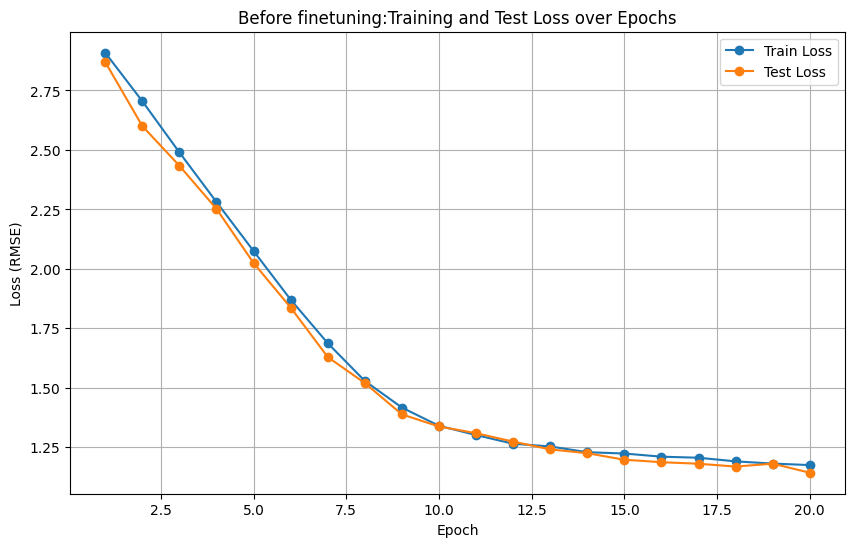

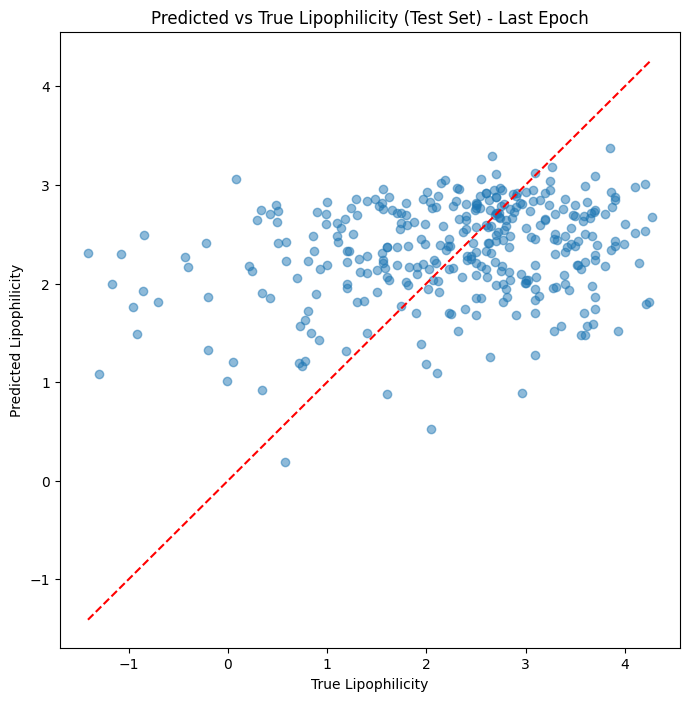

In [19]:
# TODO: your code goes here

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Plot training and test loss over epochs
epochs = list(range(1, EPOCHS+1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, np.sqrt(train_loss_history), marker='o', label='Train Loss')
plt.plot(epochs, np.sqrt(test_loss_history), marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.title('Before finetuning:Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Analyze predictions vs. true values on the test set from the last epoch
last_test_preds = np.array(all_test_predictions[-1])
last_test_targs = np.array(all_test_targets[-1])

plt.figure(figsize=(8, 8))
plt.scatter(last_test_targs, last_test_preds, alpha=0.5)
plt.xlabel('True Lipophilicity')
plt.ylabel('Predicted Lipophilicity')
plt.title('Predicted vs True Lipophilicity (Test Set) - Last Epoch')
# Plot a diagonal line for reference (perfect predictions)
min_val = min(last_test_targs.min(), last_test_preds.min())
max_val = max(last_test_targs.max(), last_test_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.show()




# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


In [ ]:
#https://github.com/huggingface/transformers/tree/main/examples/pytorch/language-modeling

In [20]:
# TODO: your code goes here
from datasets import concatenate_datasets

batch_size=16


data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

# dataloader_mlm = DataLoader(
#     finetuning_dataset, batch_size=batch_size, collate_fn=data_collator
# )

def tokenize_smiles(example):
    return tokenizer(example["SMILES"], truncation=True, padding="max_length", max_length=128)


# Concatenate the train and validation splits to use for unsupervised MLM fine-tuning , because the validation is not needed in the unsupervised finetuning because there are no labels
concat_finetuning_dataset = concatenate_datasets([train_dataset, valid_dataset])

finetuning_dataset = concat_finetuning_dataset.map(tokenize_smiles, batched=True)
finetuning_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

dataloader_mlm = DataLoader(
    finetuning_dataset, batch_size=batch_size, collate_fn=data_collator
)


model_mlm = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device)

LEARNING_RATE = 1e-7
EPOCHS_mlm = 10
optimizer_mlm = torch.optim.Adam(params=model_mlm.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS_mlm):
    model_mlm.train()
    total_loss = 0.0

    for batch in dataloader_mlm:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model_mlm(**batch)
      loss=outputs.loss

      optimizer_mlm.zero_grad()

      loss.backward()
      optimizer_mlm.step()

      total_loss += loss.item()

    total_loss /= len(dataloader_mlm)

    print(f"Unsupervised Epoch {epoch+1} -  Loss: {total_loss:.4f}")

model_mlm.save_pretrained("mlm_finetuned_model")



Unsupervised Epoch 1 -  Loss: 0.8732
Unsupervised Epoch 2 -  Loss: 0.8350
Unsupervised Epoch 3 -  Loss: 0.8153
Unsupervised Epoch 4 -  Loss: 0.7815
Unsupervised Epoch 5 -  Loss: 0.7550
Unsupervised Epoch 6 -  Loss: 0.7132
Unsupervised Epoch 7 -  Loss: 0.6996
Unsupervised Epoch 8 -  Loss: 0.6784
Unsupervised Epoch 9 -  Loss: 0.6703
Unsupervised Epoch 10 -  Loss: 0.6487


# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [21]:
# TODO: your code goes here
finetuned_model = AutoModel.from_pretrained("mlm_finetuned_model", trust_remote_code=True)

finetuned_model_regression = MoLFormerWithRegressionHead(finetuned_model).to(device)



In [22]:
EPOCHS_reg = 20
LEARNING_RATE_reg = 1e-7
optimizer_reg = torch.optim.Adam(finetuned_model_regression.parameters(), lr=LEARNING_RATE_reg)
loss_fn = nn.MSELoss()


train_loss_history = []
test_loss_history = []

for epoch in range(EPOCHS_reg):
    finetuned_model_regression.train()
    total_train_loss = 0.0

    for batch in reg_train_loader:
        input_ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        optimizer_reg.zero_grad()
        outputs = finetuned_model_regression(input_ids, mask)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer_reg.step()

        total_train_loss += loss.item() * input_ids.size(0)

    avg_train_loss = total_train_loss / len(reg_train_dataset)
    train_loss_history.append(avg_train_loss)
    print(f"Epoch {epoch+1} - Train Loss: {np.sqrt(avg_train_loss):.4f}")

    # Evaluation phase inside the epoch loop
    finetuned_model_regression.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for batch in reg_valid_loader:
            input_ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['target'].to(device)
            outputs = finetuned_model_regression(input_ids, mask)
            loss = loss_fn(outputs, targets)
            total_valid_loss += loss.item() * input_ids.size(0)

    avg_valid_loss = total_valid_loss / len(reg_valid_dataset)
    test_loss_history.append(avg_valid_loss)
    print(f"Epoch {epoch+1} - Validation Loss: {np.sqrt(avg_valid_loss):.4f}")


Epoch 1 - Train Loss: 2.1515
Epoch 1 - Validation Loss: 2.1185
Epoch 2 - Train Loss: 1.9713
Epoch 2 - Validation Loss: 1.9271
Epoch 3 - Train Loss: 1.8130
Epoch 3 - Validation Loss: 1.7740
Epoch 4 - Train Loss: 1.6631
Epoch 4 - Validation Loss: 1.6051
Epoch 5 - Train Loss: 1.5379
Epoch 5 - Validation Loss: 1.4895
Epoch 6 - Train Loss: 1.4285
Epoch 6 - Validation Loss: 1.3873
Epoch 7 - Train Loss: 1.3492
Epoch 7 - Validation Loss: 1.3076
Epoch 8 - Train Loss: 1.2912
Epoch 8 - Validation Loss: 1.2449
Epoch 9 - Train Loss: 1.2402
Epoch 9 - Validation Loss: 1.2325
Epoch 10 - Train Loss: 1.2164
Epoch 10 - Validation Loss: 1.1895
Epoch 11 - Train Loss: 1.2000
Epoch 11 - Validation Loss: 1.1751
Epoch 12 - Train Loss: 1.1883
Epoch 12 - Validation Loss: 1.1639
Epoch 13 - Train Loss: 1.1843
Epoch 13 - Validation Loss: 1.1544
Epoch 14 - Train Loss: 1.1713
Epoch 14 - Validation Loss: 1.1521
Epoch 15 - Train Loss: 1.1758
Epoch 15 - Validation Loss: 1.1448
Epoch 16 - Train Loss: 1.1662
Epoch 16 - Va

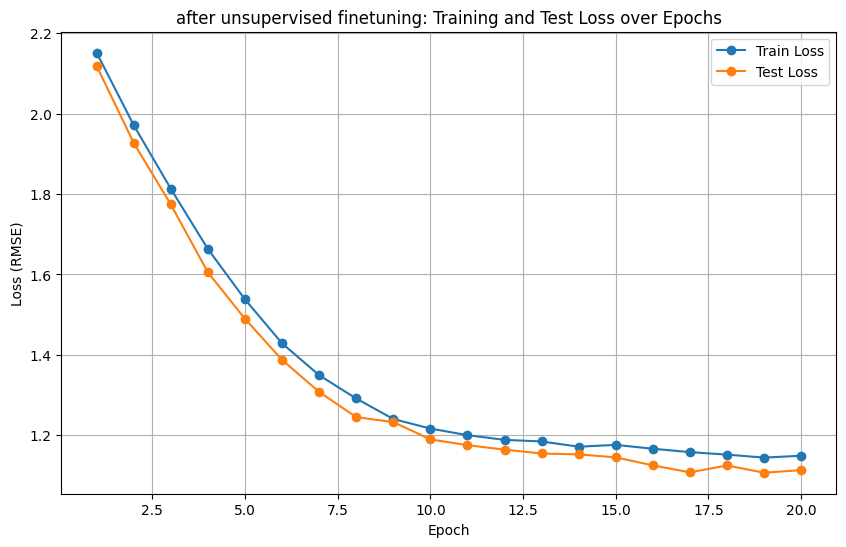

In [23]:
# Plot training and test loss over epochs
epochs = list(range(1, EPOCHS+1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, np.sqrt(train_loss_history), marker='o', label='Train Loss')
plt.plot(epochs, np.sqrt(test_loss_history), marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.title('after unsupervised finetuning: Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Evaluate Baseline Regression Model on the Test Set
regression_model.eval()
total_test_loss_baseline = 0.0
all_preds_baseline = []
all_targets_baseline = []

with torch.no_grad():
    for batch in reg_test_loader:
        input_ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = regression_model(input_ids, mask)
        loss = loss_fn(outputs, targets)
        # Multiply by batch size to get total loss across samples
        total_test_loss_baseline += loss.item() * input_ids.size(0)

        all_preds_baseline.extend(outputs.cpu().numpy())
        all_targets_baseline.extend(targets.cpu().numpy())

avg_test_loss_baseline = total_test_loss_baseline / len(reg_test_dataset)
print(f"Baseline Regression Model Test Loss: {np.sqrt(avg_test_loss_baseline):.4f}")

# Evaluate Finetuned Regression Model on the Test Set
finetuned_model_regression.eval()
total_test_loss_finetuned = 0.0
all_preds_finetuned = []
all_targets_finetuned = []

with torch.no_grad():
    for batch in reg_test_loader:
        input_ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['target'].to(device)

        outputs = finetuned_model_regression(input_ids, mask)
        loss = loss_fn(outputs, targets)
        total_test_loss_finetuned += loss.item() * input_ids.size(0)

        all_preds_finetuned.extend(outputs.cpu().numpy())
        all_targets_finetuned.extend(targets.cpu().numpy())

avg_test_loss_finetuned = total_test_loss_finetuned / len(reg_test_dataset)
print(f"Finetuned Regression Model Test Loss: {np.sqrt(avg_test_loss_finetuned):.4f}")


Baseline Regression Model Test Loss: 1.1352
Finetuned Regression Model Test Loss: 1.1009
